# SPAM SMS DETECTION

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether a given SMS is spam or not, utilizing pertinent features extracted from the text.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('Set2')

### Importing Dataset

In [2]:
train_data = pd.read_csv('Dataset/spam.csv', encoding='latin-1')

In [3]:
train_data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2033,ham,IM GONNA MISS U SO MUCH,NaN,NaN,NaN
3755,ham,Yes:)here tv is always available in work place..,NaN,NaN,NaN
1564,ham,Tmrw. Im finishing 9 doors,NaN,NaN,NaN
1356,ham,U ned to convince him tht its not possible wit...,NaN,NaN,NaN
4646,ham,God created gap btwn ur fingers so dat sum1 vr...,NaN,NaN,NaN


In [4]:
#removing unwanted columns and renaming the columns
train_data = train_data[["v1","v2"]]
train_data.rename(columns={"v1":"label","v2":"text"},inplace=True)

In [5]:
train_data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Preprocessing

In [6]:
train_data["text"].sample(5)

3859               Yep. I do like the pink furniture tho.
3471    I think IÛ÷m waiting for the same bus! Inform...
3683                           Dad says hurry the hell up
1443    Free 1st week entry 2 TEXTPOD 4 a chance 2 win...
1296    Sure! I am driving but will reach my destinati...
Name: text, dtype: object

In [7]:
import re
import string
from nltk.corpus import stopwords
import nltk
stopwd = stopwords.words('english')
def clean_text(text):
    text= text.lower() # Lowercasing the text
    text = re.sub('-',' ',text.lower())   # Replacing `x-x` as `x x`
    text = re.sub(r'http\S+', '', text) # Removing Links
    text = re.sub(f'[{string.punctuation}]', '', text) # Remove punctuations
    text = re.sub(r'\s+', ' ', text) # Removing unnecessary spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Removing single characters
    
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    text = " ".join([i for i in words if i not in stopwd and len(i)>2]) # Removing the stop words

    return text.strip()

In [8]:
train_data["clean_text"] = train_data["text"].apply(clean_text)

In [9]:
train_data.head()

,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts 21st m...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


### Splitting the data

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data["clean_text"], train_data["label"], test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [12]:
X_train.head()

1978                     boat still moms check half naked
3989    bank granite issues strong buy explosive pick ...
3935                    giving second chance rahul dengra
4078                   played smash bros ltgt religiously
4086    private 2003 account statement 07973788240 sho...
Name: clean_text, dtype: object

### Vectorizing

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
vectorizer = CountVectorizer(stop_words='english',lowercase=True)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Used Tfidf but CountVectorizer is giving more accuracy

In [14]:
X_train_vectorized.shape, X_test_vectorized.shape

((4457, 7833), (1115, 7833))

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

<Axes: xlabel='0'>

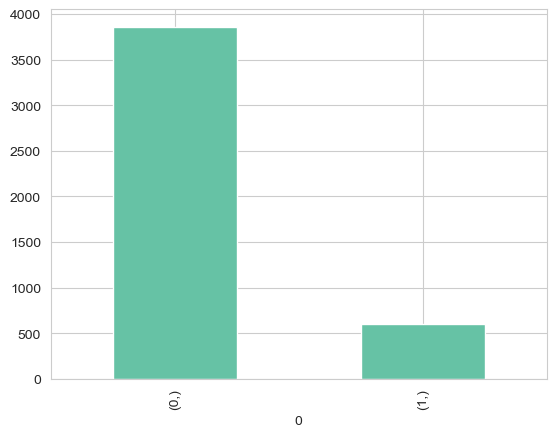

In [16]:
pd.DataFrame(y_train).value_counts().plot(kind="bar")

### Balancing both the classes using the RandomOverSampler

In [17]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)
# We will pass to it the output of Vectorizer from train data
x_train_resampled, y_train_resampled = sampler.fit_resample(
    X_train_vectorized, y_train)

<Axes: xlabel='0'>

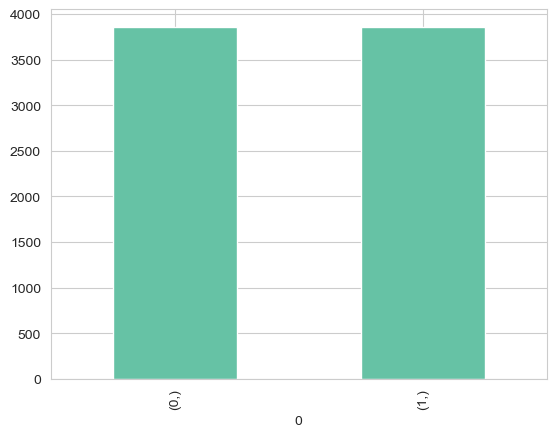

In [18]:
pd.DataFrame(y_train_resampled).value_counts().plot(kind="bar")

In [19]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score

## Modelling

### LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000,solver="sag",tol=0.001,max_iter=500,random_state=15)
lr.fit(x_train_resampled,y_train_resampled)

LogisticRegression(C=1000, max_iter=500, random_state=15, solver='sag',
                   tol=0.001)

In [21]:
print("Train Accuracy: ", lr.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", lr.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, lr.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, lr.predict(X_test_vectorized)))

Train Accuracy:  0.9998704663212435
Test Accuracy:  0.9775784753363229
Train Precision:  0.9997409997409997
Test Precision:  0.9629629629629629


### Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

cnb = MultinomialNB(alpha=0.1)
cnb.fit(x_train_resampled,y_train_resampled)

MultinomialNB(alpha=0.1)

In [23]:
print("Train Accuracy: ", cnb.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", cnb.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, cnb.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, cnb.predict(X_test_vectorized)))

Train Accuracy:  0.9920984455958549
Test Accuracy:  0.9641255605381166
Train Precision:  0.9894357124452461
Test Precision:  0.8481012658227848


### SVC

In [24]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(x_train_resampled,y_train_resampled)

SVC(random_state=42)

In [25]:
print("Train Accuracy: ", svc.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", svc.score(X_test_vectorized, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, svc.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, svc.predict(X_test_vectorized)))

Train Accuracy:  0.9998704663212435
Test Accuracy:  0.9766816143497757
Train Precision:  1.0
Test Precision:  0.9920634920634921


In [26]:
from sklearn.metrics import roc_auc_score,roc_curve

modelsdict = {"LR":lr,"CNB":cnb,"SVC":svc}

scoresdict = {}

for key,value in modelsdict.items():

    Train_ACC=accuracy_score(y_train_resampled,value.predict(x_train_resampled.toarray()))
    Train_Prec=precision_score(y_train_resampled,value.predict(x_train_resampled.toarray()))
    Test_ACC=accuracy_score(y_test,value.predict(X_test_vectorized.toarray()))
    Test_Prec=precision_score(y_test,value.predict(X_test_vectorized.toarray()))

    scoresdict[key] = [Train_ACC,Train_Prec,Test_ACC,Test_Prec]

scoresdf = pd.DataFrame(scoresdict,index=["Train_ACC","Train_Prec","Test_ACC","Test_Prec"]).T

<Axes: title={'center': 'Accuracy and Precision Scores'}, xlabel='Models', ylabel='Accuracy'>

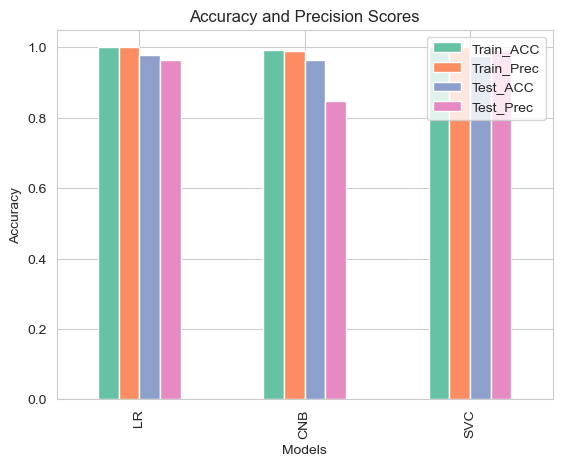

In [27]:
scoresdf.plot(kind="bar",title="Accuracy and Precision Scores",xlabel="Models",ylabel="Accuracy")